---
title:  "Association Rule using python"
excerpt: "python 으로 하는 연관성분석"

categories:
  - Machine-Learning
tags:
  - Recomandation
  - association rule
  - 장바구니 분석
  - 연관성 분석
last_modified_at: 2020-05-03T21:15:00-05:00
---

연관성분석은 흔히, '장바구니'분석으로 많이 알려져있다.  
associtaion_rule, A Priori Algorithm 으로 불리기도 한다.

[참고자료1 - 한국blog](https://ratsgo.github.io/machine%20learning/2017/04/08/apriori/)  
[참고자료2 - Medium](https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c)  

컨셉은, 고객들이 사간 장바구니 LIST 가 있다고 할때, 물건A를 샀을때, 함께 살 확률이 높은 물건은 무엇인가? B? C? 이런 의문을 검증하는 것이다.

여기서 알아둘어야 할 것은 연관성분석을 할때, 이른바 Rule를 찾을대, 여러 방식이 있는데   
그중, 빈발항목들에 대해서, 연관성 규칙을 찾는것이 본 posting에서 다루는 것이고, 이것이 가장 Basic 이라 할 수 있다.  

1) 모든 가능한 항목집합의 개수(M)를 줄이는 전략 ▶ Apriori algorithm  
2) Transaction 개수(N)을 줄이는 전략 ▶ DHP algorithm  
3) 비교하는 수(W)를 줄이는 전략 ▶ FP-growth algorithm  

출처: https://rfriend.tistory.com/192 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

필수적인 용어를 미리 알아보자  
* `support` : rule의 조건이 일어날 확률. A면 B 이다, 되기 위한 조건 A 가 일어날 확률을 일컫는다.  
여기서 A 는 표현은 A 사건이라 했지만, A,B 2개(AnB), A,B,C 3개가 될 수도 있는것이다.  
The support of X with respect to T is defined as the proportion of transactions t in the dataset which contains the itemset X. -> [wikipedia](https://en.wikipedia.org/wiki/Association_rule_learning#Support)

![img](../dataset/association_rule/asso_01.PNG)

* `confindence` : rule의 조건이 일어났을대, 결과가 일어날 확률. P(A,B) => P(A ∩ B)  
즉 __confidence는 P(B|A) 조건부 확률__이다.  
P(A ∩ B) = P(A)* P(B|A)  

item 집합간의 연관성 강도를 측정하는데, 사용된다고 보면 된다.

![img](../dataset/association_rule/asso_02.PNG)

* `lift` : 조건과 결과가 각각 독립적이라고 가정했을때, 보다 얼마나 더 좋은가?  

다만, 위에서 언급한 모든 A,B 의 표현이 개별 item 으로만 소개가 되었는데, 실전에서는 헷갈리지 말아야 하는 것이  
P(A n (BnC)) , P(A n (BnCnD)), P((AnB) n (CnD)) 이런 조합으로도 계산이 이루어지고 있음을 알아야 한다.

![img](../dataset/association_rule/asso_03.PNG)

# 연관성 분석 수행하기 (연관성있는 Rule 찾기)
### 최소 지지도 정하기

규칙을 생성할때, 주의할 점은, 기본적으로 무수히 많은 제품이 있고, 많은 조합이 생길수 있다. 그렇다면, 이 모든 조합을 계산한다는 것은 사실상 불가능한 일일 것이다.  
(모든 case 를 가정하면, 2개 묶음만 생각하더라도, n*(n-1) 이며, 3개는 n(n-1)(n-2)로  된다.  
그렇기 때문에, 항상 최소 지지도(확률)을 설정하고 rule 탐색 과정으로 들어가야 한다.  

최소 지지도를 구할때, P(특정 s item)의 값이 최소 지지도를 넘지 못한다면, 그 이후, s item 이 들어간 조합은 고려할 필요가 없다.   
왜냐하면, s 가 있는 조합은 어떤 조합이 되는지 교집합의 확률이 s 만의 확률(지지도)를 넘지 못하기 때문이다. 

아래 그림을 보면, 좀 더 이해하기 쉬울 것이다.  아래 그림은 최소 지지도를 0.5 = (2/4) 로 한 경우이다.  
통상 Transaction을 전체로 최소지지도를 2로표현하기도 한다.

![img](../dataset/association_rule/fequent.PNG)

### 최소지지도가 넘는 조합들에 대하여, confidence 와 lift 를 구하고, lift 순서데로, 연관성Rule 이 가장 높은 것을 찾는다.

In [1]:
0.2/0.08

2.5

### 실습해보기 01 이론처럼 구현한다. 02에서는 library 활용
실습코드 활용주소(https://frhyme.github.io/associative_mining/)

In [2]:
import pandas as pd
import numpy as np
import itertools ## 조합만들때, 필요하다.

In [3]:
mdf = pd.read_csv('D:/★2020_ML_DL_Project/Alchemy/dataset/marketbasket.csv',encoding='UTF8',header='infer')

In [4]:
print(mdf.shape) ## 트랜잭션 수는 1361 건이다.
print(mdf.columns) ## 품목이 255건이나 된다.
mdf.head()

(1361, 255)
Index([' Hair Conditioner', ' Lemons', ' Standard coffee',
       ' Frozen Chicken Wings', ' 98pct. Fat Free Hamburger', ' Sugar Cookies',
       ' Onions', ' Deli Ham', ' Dishwasher Detergent', ' Beets',
       ...
       ' Lollipops', ' Plain White Bread', ' Blueberry Yogurt',
       ' Frozen Chicken Thighs', ' Mixed Vegetables', ' Souring Pads',
       ' Tuna Spread', ' Toilet Paper', ' White Wine', ' Columbian Coffee'],
      dtype='object', length=255)


,Hair Conditioner,Lemons,Standard coffee,Frozen Chicken Wings,98pct. Fat Free Hamburger,Sugar Cookies,Onions,Deli Ham,Dishwasher Detergent,Beets,...,Lollipops,Plain White Bread,Blueberry Yogurt,Frozen Chicken Thighs,Mixed Vegetables,Souring Pads,Tuna Spread,Toilet Paper,White Wine,Columbian Coffee
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
new_columns = mdf.columns.str.strip().to_list()

In [6]:
mdf.columns = new_columns

In [7]:
mdf.head(2)

,Hair Conditioner,Lemons,Standard coffee,Frozen Chicken Wings,98pct. Fat Free Hamburger,Sugar Cookies,Onions,Deli Ham,Dishwasher Detergent,Beets,...,Lollipops,Plain White Bread,Blueberry Yogurt,Frozen Chicken Thighs,Mixed Vegetables,Souring Pads,Tuna Spread,Toilet Paper,White Wine,Columbian Coffee
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


이론에 충실하게, 직접 코딩을 참고자료에서, 했길래 그대로 차용했다.  
### support 함수 + 최소지지도 만족하는 조합 찾는 함수 만들기

In [17]:
def support(df, item_lst):
    return (df[list(item_lst)].sum(axis=1)==len(item_lst)).mean() ## columns 의 single col를 list형변환 이후, 
    ## df[list(item_lst)] -> item_lst(list type)을 다시 한번 list로 형변환해서, [[]] 으로 받음.

In [18]:
rslt = support(mdf, ['Lemons'])
print(rslt)

0.030124908155767818


상기 함수는 원본인데, 특별한 거 없이, 각 item이 전체 트랜색션에서, 발생하는 확률P(A) 를 구해서, float64 형태의 값으로 돌려준다.  
의미는 같게해서, 재정의해서 사용하면,

In [19]:
print(mdf.isnull().any().sum()) ## 우선, 각 컬럼별 null 값은 없다.
print(mdf[mdf > 1].any().sum()) ## 데이터셋에서는 1 이상의 값을 가지는 value 값도 없다.

0
0


In [20]:
def support_me(df, items_lst): ## dataframe 형태에서만, sum(axis=1) 이 가능하기에, single item 처음부터 parmeter를 list 형태로만 받는다.
    items_lst = items_lst if isinstance(items_lst,list) else list(items_lst)
    a = np.sum(mdf.loc[:,items_lst].sum(axis=1)==len(items_lst)) ## 해당 item 집합이 발생한 확률. 1개 조합일때는 1개의 빈도수가 되고, 2개 이상일때는 해당 조합의 교집합 빈도수가 된다..
    b = df.loc[:,items_lst].shape[0] ## 전체 transaction 수
    return a/b   

In [21]:
q = list('ABCDE')
# print(q.__class__)
if isinstance(q,list):
    print('love')

love


In [22]:
rslt01 = support_me(mdf, ('Lemons','Onions')) ## 'Lemons','Onions'
rslt02 = support_me(mdf, ['Lemons']) ## 'Lemons','Onions'
print(rslt01,rslt02)

0.01689933872152829 0.030124908155767818


이해하기 쉽게 여기서는 support_me 함수를 사용한다.

In [23]:
aa = list('ABCDE')
print(aa)
print(list(itertools.combinations(aa, 3)))
print(type(list(itertools.combinations(aa, 3))[0]))
print(list(itertools.combinations(aa, 6))) ## 가능조합이 넘어선 parameter가 입력되면, 빈 list를 던진다.

['A', 'B', 'C', 'D', 'E']
[('A', 'B', 'C'), ('A', 'B', 'D'), ('A', 'B', 'E'), ('A', 'C', 'D'), ('A', 'C', 'E'), ('A', 'D', 'E'), ('B', 'C', 'D'), ('B', 'C', 'E'), ('B', 'D', 'E'), ('C', 'D', 'E')]
<class 'tuple'>
[]


In [24]:
## 모든 조합에 대해서, 최소 지지도 값을 넘는 조합 만들기
def make_all_set_over_support(df, support_threshold):
    items = []
    single_items = [col for col in df.columns if support_me(df, [col]) > support_threshold] # size 1 items original,threshold 값을 넘는 것만 1차로 추리고
    
    size = 2 ## 2개 조합부터 시작해서~
    while True:
        new_items = []
        for item_cand in itertools.combinations(single_items, size): ## 각 item집합에서, 2개,3개~ combination 조합 값을 가져온다.
#             print(item_cand,df.loc[:,item].sum()/df.loc[:,item].count())
            if support_me(df, item_cand) > support_threshold:
                new_items.append(list(item_cand))
        if len(new_items)==0: ## 가능조합이 넘어선 parameter가 입력되면, 빈 list를 던진다.
            break
        else:
            items+=new_items
            size+=1 ## 1개씩 계속 올린다.
    items += [ [s] for s in single_items]# 마지막에, single_items 값들을 각각 list로 변화시켜서 기존 2개이상 조합들을 구한 값에 합친다.
    return items

In [25]:
over_support_lst = make_all_set_over_support(mdf, 0.07)# 0.05로 하면 두 개짜리도 가능하며, 0.07 일 경우는 1개짜리 조합밖에 없음.

In [27]:
over_support_lst

[['98pct. Fat Free Hamburger'],
 ['Onions'],
 ['Potato Chips'],
 ['Hot Dogs'],
 ['2pct. Milk'],
 ['Eggs'],
 ['White Bread'],
 ['Cola'],
 ['Toothpaste'],
 ['Hamburger Buns'],
 ['Wheat Bread'],
 ['Sweet Relish'],
 ['Toilet Paper']]

### confidence 함수 만들기

In [18]:
def make_confidence_lst(df, item_set_over_support, confidence_threshold): ## confidence_threshold
    r_lst = []
    for item1 in item_set_over_support: ## 2중 for 문
        for item2 in item_set_over_support:
            if len(set(item1).intersection(set(item2)))==0: ## 2집합의 교집합이 없으면, 신뢰도 값(=조건부확률값) 계산을 진행한다. 다른말로, 상호배반성이 없으면~
                conf = support_me(df, set(item1).union(set(item2)))/ support_me(df, item1) ## item1이 조건부 집합
                if conf > confidence_threshold:
                    r_lst.append((item1, item2, conf))
            else:
                continue
    return sorted(r_lst, key=lambda x: x[2], reverse=True)

`len(set(item1).intersection(set(item2)))==0` 상기 함수에서, 이 부분을 주목해야 한다.   

**confidence 는 조건절이 일어났을때, 결과절의 확률을 구하는 P(A|B) [B조건이 일어났을때, A결과절 확률]**  

정의한 함수식을 해석하면, P((AnB)|(BnC)) 의 상황에서는 else 절로 빠지고 confidence 계산을 하지 않는다. B 가 교집합이기 때문이다.  
이렇게 함수를 정의한 이유는, 연관성분석이 `상호배반성(mutually exclusive)`를 가정하기 때문이다.  

예컨대 ‘달걀을 구매하는 사람들은 라면도 함께 산다’를 보자. 여기에서 ‘달걀 구매’가 조건절, ‘라면 구매’가 결과절이며 각각의 아이템 집합은 ‘달걀’, ‘라면’이 된다.  
단 여기에서 조건절 아이템 집합과 결과절 아이템 집합은 말 그대로 집합, 여러개 아이템이 들어가도 되지만 상호배반(mutually exclusive)이어야 된다는 것으로,  
다시 말해 조건절에 달걀이 들어가 있다면 결과절에는 달걀이 포함되어서는 안된다는 뜻이다.

### lift 함수 만들기

In [19]:
def make_lift_lst(df, item_set_over_support, lift_threhsold):
    r_lst = []
    for item1 in item_set_over_support:  ## 2중 for 문
        for item2 in item_set_over_support: 
            if len(set(item1).intersection(set(item2)))==0: ## 2집합의 교집합이 없으면, 신뢰도 값(=조건부확률값) 계산을 진행한다. 다른말로, 상호배반성이 없으면~
                lift = support_me(df, list(set(item1).union(set(item2)))) ## 최초 수식에서, P(AnB)에 대응되는 개념
                lift /= support(df, item1) ## 최초 수식에서, P(A)에 대응되는 개념
                lift /= support(df, item2) ## 최초 수식에서, P(B)에 대응되는 개념
                if lift > lift_threhsold:
                    r_lst.append((item1, item2, lift))
            else:
                continue
    return sorted(r_lst, key=lambda x: x[2], reverse=True)

### 실행해보기

In [20]:
print("over support list")
print(over_support_lst)
print("-----------------")
print("over confidence list")
for a, b, conf in  make_confidence_lst(mdf, over_support_lst, 0.53): ## threshold 는 참조자료를 그대로 차용했다.
    print("{} => {}: {}".format(a, b, conf))
print("-----------------")
print("over lift list")
for a, b, lift in  make_lift_lst(mdf, over_support_lst, 5.6): ## threshold 는 참조자료를 그대로 차용했다.
    print("{} => {}: {}".format(a, b, lift))
print("-----------------")

over support list
[['98pct. Fat Free Hamburger'], ['Onions'], ['Potato Chips'], ['Hot Dogs'], ['2pct. Milk'], ['Eggs'], ['White Bread'], ['Cola'], ['Toothpaste'], ['Hamburger Buns'], ['Wheat Bread'], ['Sweet Relish'], ['Toilet Paper']]
-----------------
over confidence list
['Hamburger Buns'] => ['98pct. Fat Free Hamburger']: 0.6804123711340206
['Toothpaste'] => ['White Bread']: 0.6018518518518519
['Toothpaste'] => ['Eggs']: 0.5648148148148148
['Wheat Bread'] => ['White Bread']: 0.5619047619047619
['Wheat Bread'] => ['2pct. Milk']: 0.5523809523809524
['Sweet Relish'] => ['Hot Dogs']: 0.5517241379310344
['Toothpaste'] => ['2pct. Milk']: 0.5462962962962963
['Onions'] => ['White Bread']: 0.5321100917431193
-----------------
over lift list
['Hamburger Buns'] => ['98pct. Fat Free Hamburger']: 7.291663284357497
['98pct. Fat Free Hamburger'] => ['Hamburger Buns']: 7.291663284357496
['Hot Dogs'] => ['Sweet Relish']: 5.9594964422550625
['Sweet Relish'] => ['Hot Dogs']: 5.959496442255062
['Tooth

# python 정식 library로 해보기_01
참고 blog (https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c)

mdf 데이터를 사용하기 전에, 참고 Blog에서 활용한 데이터를 가지고 연습한 이후, 해본다.

In [10]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
df = pd.read_csv('D:/★2020_ML_DL_Project/Alchemy/dataset/retail_dataset.csv',encoding='UTF8',header='infer')

In [23]:
df.columns = ['item00','item01','item02','item03','item04','item05','item06']
df.head()

,item00,item01,item02,item03,item04,item05,item06
0,Bread,Wine,Eggs,Meat,Cheese,Pencil,Diaper
1,Bread,Cheese,Meat,Diaper,Wine,Milk,Pencil
2,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
3,Cheese,Meat,Eggs,Milk,Wine,NaN,NaN
4,Meat,Pencil,Wine,NaN,NaN,NaN,NaN


In [50]:
## 전체 item 집합 확인하기
total_item = None
for col in df.columns:
    it = df[col].unique()
    if total_item is None:
        total_item = set(it)
    else:
        total_item.union(set(it))
total_item_lst = list(total_item)

In [52]:
total_item_lst

['Wine',
 'Meat',
 'Eggs',
 'Bagel',
 'Bread',
 'Milk',
 'Pencil',
 'Diaper',
 'Cheese']

In [53]:
print(len(total_item_lst),type(total_item_lst),'\n',total_item_lst)

9 <class 'list'> 
 ['Wine', 'Meat', 'Eggs', 'Bagel', 'Bread', 'Milk', 'Pencil', 'Diaper', 'Cheese']


필자는 여기서, 참조Blog에서 제시한 custom함수보다, 좀 다르게 ohe 를 구성해보았다.  
우선 melt 함수를 활용하려고 하며, 이를 위해선 transaction 에 해당하는 row_index를 컬럼으로 끄집어낸다.

In [88]:
from sklearn import preprocessing as pre
lb = pre.LabelBinarizer()
lb.fit(total_item_lst)
# ohe = pre. OneHotEncoder(handle_unknown='ignore',sparse=False)
# ohe.fit([total_item_lst])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [125]:
lb.classes_

array(['Bagel', 'Bread', 'Cheese', 'Diaper', 'Eggs', 'Meat', 'Milk',
       'Pencil', 'Wine'], dtype='<U6')

In [126]:
lb.transform(['Bread'])[0] ## 항상 2차원을 return 한다.

array([0, 1, 0, 0, 0, 0, 0, 0, 0])

In [127]:
## 변경된 결과 저장 껍데기
df01 = np.zeros((df.shape[0],len(total_item_lst)))
df01 = pd.DataFrame(data=df01,columns=lb.classes_)
print(df01.shape)
df01.head(2)

(315, 9)


,Bagel,Bread,Cheese,Diaper,Eggs,Meat,Milk,Pencil,Wine
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
x[~pd.isnull(x)]

array([0, 0, 0, 0, 0, 1, 0, 0, 0])

In [129]:
for index, row in df.iterrows():
    by_row = df.iloc[index].values    
    by_row = by_row[~pd.isnull(by_row)] ## nan 값은 lb 에서,변환 에러를 일으키기 때문에 제거한다.
    ohe_rslt = np.zeros(len(total_item_lst))
    for item in by_row:
        x = lb.transform([item])[0] ## LabelBinarizer 의 경우, ## 항상 2차원을 return 한다.
        ohe_rslt += x
#     print(ohe_rslt)
    df01.iloc[index] = ohe_rslt

**blog 원본 코드 start**

In [115]:
items = (df['item00'].unique())
items

def custom(df):
    encoded_vals = []
    for index, row in df.iterrows():
        labels = {}
        uncommons = list(set(items) - set(row))
        commons = list(set(items).intersection(row))
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    ohe_df = pd.DataFrame(encoded_vals)
    return ohe_df

In [116]:
ohe_df = custom(df)

**blog 원본 코드 End**

필자가 만든것과 비교해보면,

In [130]:
print("before_ohe data shape : {}".format(df.shape))
print("after_ohe data shape : {}".format(ohe_df.shape))
print("after_ohe bymyself shape : {}".format(df01.shape))

before_ohe data shape : (315, 7)
after_ohe data shape : (315, 9)
after_ohe bymyself shape : (315, 9)


In [131]:
ohe_df.head()

,Bagel,Bread,Cheese,Diaper,Eggs,Meat,Milk,Pencil,Wine
0,0,1,1,1,1,1,0,1,1
1,0,1,1,1,0,1,1,1,1
2,0,0,1,0,1,1,1,0,1
3,0,0,1,0,1,1,1,0,1
4,0,0,0,0,0,1,0,1,1


In [136]:
df01 = df01.astype(int)
df01.head()

,Bagel,Bread,Cheese,Diaper,Eggs,Meat,Milk,Pencil,Wine
0,0,1,1,1,1,1,0,1,1
1,0,1,1,1,0,1,1,1,1
2,0,0,1,0,1,1,1,0,1
3,0,0,1,0,1,1,1,0,1
4,0,0,0,0,0,1,0,1,1


## mlxtend.frequent_patterns  
상기 library 에서는 apriori 와 association_rules 2가지가 있다.
(http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/#apriori)

### __apriori__    

__이 라이브러리의 목적은 최소지지도를 충족하는 집단을 만들어내는데 있다. 이후, 이를 가지고 Asscoiation rule 모듈에 적용한다.__

apriori(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0, low_memory=False)
- min_support : float (default: 0.5)  
  A float between 0 and 1 for minumum support of the itemsets returned. The support is computed as the fraction transactions_where_item(s)_occur / total_transactions.

- use_colnames : bool (default: False)  
  If True, uses the DataFrames' column names in the returned DataFrame instead of column indices.

- max_len : int (default: None)  
  Maximum length of the itemsets generated. If None (default) all possible itemsets lengths (under the apriori condition) are evaluated.

- verbose : int (default: 0)  
  Shows the number of iterations if >= 1 and low_memory is True.  
  If=1 and low_memory is False, shows the number of combinations.
  
- low_memory : bool (default: False)  
  If True, uses an iterator to search for combinations above min_support.  
  Note that while low_memory=True should only be used for large dataset if memory resources are limited, because this implementation is approx. 3-6x slower than the default.

In [137]:
freq_items = apriori(df01, min_support=0.2, use_colnames=True, verbose=1)
freq_items.head(7)

Processing 4 combinations | Sampling itemset size 4 3


,support,itemsets
0,0.425397,(Bagel)
1,0.504762,(Bread)
2,0.501587,(Cheese)
3,0.406349,(Diaper)
4,0.438095,(Eggs)
5,0.476190,(Meat)
6,0.501587,(Milk)


### __association_rules__  
association_rules(df, metric='confidence', min_threshold=0.8, support_only=False)  
- df : pandas DataFrame  
  pandas DataFrame of frequent itemsets with columns ['support', 'itemsets']
- metric : string (default: 'confidence')  
  Metric to evaluate if a rule is of interest. Automatically set to 'support' if support_only=True. Otherwise, supported metrics are 'support', 'confidence', 'lift',
- min_threshold : float (default: 0.8)  
  Minimal threshold for the evaluation metric, via the metric parameter, to decide whether a candidate rule is of interest.  
- support_only : bool (default: False)  
  Only computes the rule support and fills the other metric columns with NaNs. This is useful if:  
  a) the input DataFrame is incomplete, e.g., does not contain support values for all rule antecedents and consequents  
  b) you simply want to speed up the computation because you don't need the other metrics.  

In [140]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.6)
rules.sort_values(by='lift',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,"(Milk, Meat)",(Cheese),0.244444,0.501587,0.203175,0.831169,1.657077,0.080564,2.952137
8,"(Eggs, Meat)",(Cheese),0.266667,0.501587,0.215873,0.809524,1.613924,0.082116,2.616667
9,"(Cheese, Meat)",(Eggs),0.323810,0.438095,0.215873,0.666667,1.521739,0.074014,1.685714
10,"(Eggs, Cheese)",(Meat),0.298413,0.476190,0.215873,0.723404,1.519149,0.073772,1.893773
13,"(Cheese, Milk)",(Meat),0.304762,0.476190,0.203175,0.666667,1.400000,0.058050,1.571429


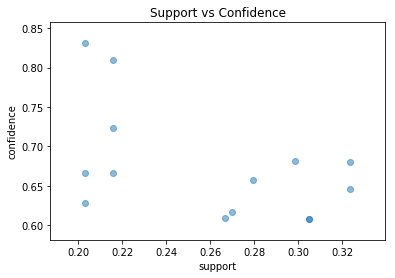

In [141]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

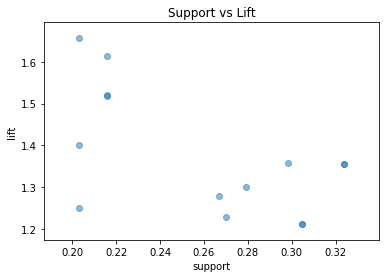

In [143]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

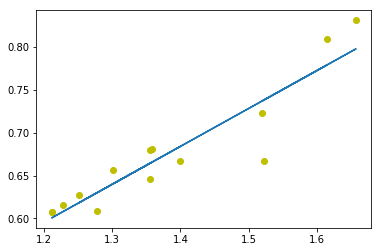

In [144]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'],fit_fn(rules['lift']))

## mdf 데이터를 가지고 활용해본다면,

In [8]:
mdf.head()

,Hair Conditioner,Lemons,Standard coffee,Frozen Chicken Wings,98pct. Fat Free Hamburger,Sugar Cookies,Onions,Deli Ham,Dishwasher Detergent,Beets,...,Lollipops,Plain White Bread,Blueberry Yogurt,Frozen Chicken Thighs,Mixed Vegetables,Souring Pads,Tuna Spread,Toilet Paper,White Wine,Columbian Coffee
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
freq_items = apriori(mdf, min_support=0.07, use_colnames=True, verbose=1)
freq_items

Processing 156 combinations | Sampling itemset size 2


,support,itemsets
0,0.093314,(98pct. Fat Free Hamburger)
1,0.080088,(Onions)
2,0.097722,(Potato Chips)
3,0.092579,(Hot Dogs)
4,0.109478,(2pct. Milk)
5,0.122704,(Eggs)
6,0.119030,(White Bread)
7,0.077884,(Cola)
8,0.079353,(Toothpaste)
9,0.071271,(Hamburger Buns)


In [14]:
freq_items_01 = apriori(mdf, min_support=0.05, use_colnames=True, verbose=1)
freq_items_01

Processing 3 combinations | Sampling itemset size 3e 2


,support,itemsets
0,0.058780,(Hair Conditioner)
1,0.093314,(98pct. Fat Free Hamburger)
2,0.055107,(Sugar Cookies)
3,0.080088,(Onions)
4,0.097722,(Potato Chips)
5,0.051433,(Waffles)
6,0.055841,(Plums)
7,0.054372,(Mushrooms)
8,0.056576,(Orange Juice)
9,0.050698,(Sour Cream)


In [15]:
print(freq_items.shape,freq_items_01.shape)

(13, 2) (42, 2)


over_support_lst : 날코딩으로 만든 0.07 이상일때의 빈번조합 갯수. mlxtend 와 값이 차이가 나는지 비교해보면, 아래 13과 같이 동일한 조합을 만들었음을 알 수 있다.

In [29]:
print(len(over_support_lst))

13


### 쌩코딩결과와의 association_rules 비교

min_support_0.07 로 했더니, 빈번집합이, 1개 그룹것만 나온다. 일단, 위에서 쌩코딩으로 구한것과 같다.  
다만, 하기 association_rules 에서는 결과같이 위에와 좀 다르다.  

over confidence list : 0.53
['Hamburger Buns'] => ['98pct. Fat Free Hamburger']: 0.6804123711340206  
['Toothpaste'] => ['White Bread']: 0.6018518518518519  
['Toothpaste'] => ['Eggs']: 0.5648148148148148  
['Wheat Bread'] => ['White Bread']: 0.5619047619047619  
['Wheat Bread'] => ['2pct. Milk']: 0.5523809523809524  
['Sweet Relish'] => ['Hot Dogs']: 0.5517241379310344  
['Toothpaste'] => ['2pct. Milk']: 0.5462962962962963  
['Onions'] => ['White Bread']: 0.5321100917431193  
-----------------  
over lift list : 5.6  
['Hamburger Buns'] => ['98pct. Fat Free Hamburger']: 7.291663284357497  
['98pct. Fat Free Hamburger'] => ['Hamburger Buns']: 7.291663284357496  
['Hot Dogs'] => ['Sweet Relish']: 5.9594964422550625  
['Sweet Relish'] => ['Hot Dogs']: 5.959496442255062  
['Toothpaste'] => ['Wheat Bread']: 5.640828924162257  
['Wheat Bread'] => ['Toothpaste']: 5.640828924162257  

#### Rule 구하기

In [34]:
rule_rslt_conf = association_rules(freq_items, metric="confidence", min_threshold=0.01) ## 0.53
rule_rslt_lift = association_rules(freq_items, metric="lift", min_threshold=1.0)  ## 5.6

In [35]:
rule_rslt_conf

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [36]:
rule_rslt_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


"freq_items" 집합으로 그렸을때, 도출되는 값이 없다. threshold 값을 낮추어도 마찬가지이다.  
이는 freq_items이 2개이상 집합을 가진 frozen_set 이 없기 때문이다.

In [67]:
rule_rslt_conf_01 = association_rules(freq_items_01, metric="confidence", min_threshold=0.04) ## 0.53
rule_rslt_lift_01 = association_rules(freq_items_01, metric="lift", min_threshold=3.0) ## 0.53 / 5.6

In [74]:
rule_rslt_conf_01.sort_values(by='confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Potato Chips),(White Bread),0.097722,0.119030,0.051433,0.526316,4.421702,0.039801,1.859825
2,(2pct. Milk),(Eggs),0.109478,0.122704,0.052168,0.476510,3.883414,0.038734,1.675861
4,(2pct. Milk),(White Bread),0.109478,0.119030,0.051433,0.469799,3.946889,0.038402,1.661576
7,(White Bread),(Eggs),0.119030,0.122704,0.055107,0.462963,3.773010,0.040501,1.633586
6,(Eggs),(White Bread),0.122704,0.119030,0.055107,0.449102,3.773010,0.040501,1.599152
1,(White Bread),(Potato Chips),0.119030,0.097722,0.051433,0.432099,4.421702,0.039801,1.588793
5,(White Bread),(2pct. Milk),0.119030,0.109478,0.051433,0.432099,3.946889,0.038402,1.568093
3,(Eggs),(2pct. Milk),0.122704,0.109478,0.052168,0.425150,3.883414,0.038734,1.549137


In [75]:
rule_rslt_lift_01.sort_values(by='lift',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Potato Chips),(White Bread),0.097722,0.119030,0.051433,0.526316,4.421702,0.039801,1.859825
1,(White Bread),(Potato Chips),0.119030,0.097722,0.051433,0.432099,4.421702,0.039801,1.588793
5,(White Bread),(2pct. Milk),0.119030,0.109478,0.051433,0.432099,3.946889,0.038402,1.568093
4,(2pct. Milk),(White Bread),0.109478,0.119030,0.051433,0.469799,3.946889,0.038402,1.661576
3,(Eggs),(2pct. Milk),0.122704,0.109478,0.052168,0.425150,3.883414,0.038734,1.549137
2,(2pct. Milk),(Eggs),0.109478,0.122704,0.052168,0.476510,3.883414,0.038734,1.675861
7,(White Bread),(Eggs),0.119030,0.122704,0.055107,0.462963,3.773010,0.040501,1.633586
6,(Eggs),(White Bread),0.122704,0.119030,0.055107,0.449102,3.773010,0.040501,1.599152


In [50]:
## 참고 : freq_items_01 에서, 2개집합 항목으로 구성된 물품들 (support : 0.05)
freq_items_01[freq_items_01.itemsets.apply(lambda x : len(list(x))) > 1]

,support,itemsets
38,0.051433,"(Potato Chips, White Bread)"
39,0.052168,"(2pct. Milk, Eggs)"
40,0.051433,"(2pct. Milk, White Bread)"
41,0.055107,"(Eggs, White Bread)"


__`association_rules` 을 구할때, confidence,lift 모두, 파라미터로 받는 조합이 1개 조합(=frozen_set 이 1개로만 구성된 조합)은 계산에서 제외된다.__  

- freq_items 집합에서와 같이, 2개 조합이 없는 것들은 계산에서 제외되므로, 아무리 threshold값을 낮추어도, 도출되는 rule 집합은 없다.
- 반면, freq_items_01 집합 처럼 최소 2개 조합이 나온 상태에서 값을 구할 수 있는 것으로 보인다.  

> freq_items_01 기준으로 보면,  
최소지지도 그룹에서, 2개 조합이 4개가 나오니, 순서를 고려하여, 최종적으로 lift가 8개 도출되었다(4*2)  
기본적으로  association_rules 은 빈번 그룹이 나오게 되었을때, 1개 그룹으로는 구하지 않는 것으로 보인다.